### Cell 1 - Imports

In [1]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam


### Cell 2 - Processing the file

In [2]:
DATASET_PATH = "Data/genres_original"
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
file_paths = []
y = []

# Iterate through each genre and load the audio files
for genre in genres:
    genre_path = os.path.join(DATASET_PATH, genre)
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            if file.endswith(".wav"):
                file_path = os.path.join(genre_path, file)
                try:
                    # Add file path to the list
                    file_paths.append(file_path)
                    # Assign label based on genre index
                    y.append(genres.index(genre))
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    continue

# Print the number of loaded files and labels
print("Files loaded:", len(file_paths))
print("Labels loaded:", len(y))
print("Genres loaded:", len(genres))


Files loaded: 1000
Labels loaded: 1000
Genres loaded: 10


### Cell 3 - Feature extraction

In [3]:
def extract_mfcc(file_path, sr=22050, n_mfcc=13):
    try:
        signal, sr = librosa.load(file_path, sr=sr)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
        return mfcc.T  # Transpose to have time steps as rows
    except Exception as e:
        return None  # Return None if there is an error

# Apply MFCC extraction to all files and store in x_mfcc
x_mfcc = [mfcc for file_path in file_paths if (mfcc := extract_mfcc(file_path)) is not None]

print(f"Extracted MFCC features for {len(x_mfcc)} files.")


Extracted MFCC features for 1000 files.


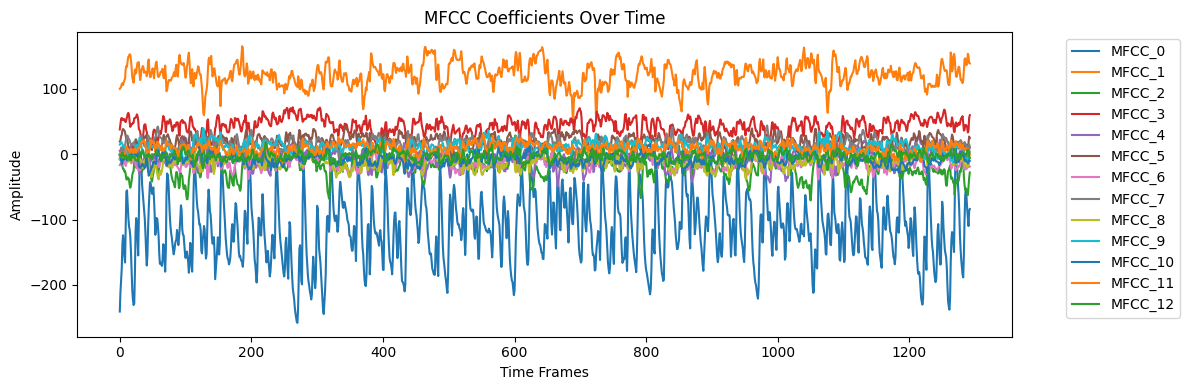

In [4]:
import matplotlib.pyplot as plt
sample_idx = 0  # First file
plt.figure(figsize=(12,4))
for i in range(13):
    plt.plot(x_mfcc[sample_idx][:,i], label=f'MFCC_{i}')
plt.title("MFCC Coefficients Over Time")
plt.xlabel("Time Frames")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Cell 4 - Pad and normalise samples

In [4]:
# Print the first MFCC features safely
print(f"Number of extracted MFCCs: {len(x_mfcc)}")
print(f"First MFCC shape: {x_mfcc[0].shape}")

# Find the maximum length of MFCC sequences
max_length = max(len(mfcc) for mfcc in x_mfcc)

# Pad sequences to match max length
x_padded = pad_sequences(x_mfcc, maxlen=max_length, dtype='float32', padding='post')

# Normalize features safely
max_vals = np.max(np.abs(x_padded), axis=1, keepdims=True)
max_vals[max_vals == 0] = 1  # Prevent division by zero
x_padded = x_padded / max_vals

# Convert genre labels to one-hot encoding
y_encoded = to_categorical(y, num_classes=len(genres))

# Check the final shape of the data
print(f"Shape of x_padded: {x_padded.shape}")
print(f"Shape of y_encoded: {y_encoded.shape}")


Number of extracted MFCCs: 1000
First MFCC shape: (1293, 13)
Shape of x_padded: (1000, 1320, 13)
Shape of y_encoded: (1000, 10)


### Cell 5 - Train test split

In [5]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

# Check the shapes of the train and test sets
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of x_train: (800, 1320, 13)
Shape of x_test: (200, 1320, 13)
Shape of y_train: (800, 10)
Shape of y_test: (200, 10)


### Cell 6 - Flatten data for SVM

In [6]:
# Flatten the data for SVM
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_test_flattened = x_test.reshape(x_test.shape[0], -1)

# Convert one-hot encoded labels back to integers
y_train_flattened = np.argmax(y_train, axis=1)
y_test_flattened = np.argmax(y_test, axis=1)


### Cell 7 - Training SVM model

In [7]:
# Train the SVM model
svm_model = SVC()
svm_model.fit(x_train_flattened, y_train_flattened)

# Predict on the test set
y_pred = svm_model.predict(x_test_flattened)


### Cell 8 - Defining CNN

In [8]:
# Define the CNN model architecture
cnn_model = Sequential([
    # First convolutional layer with 'same' padding
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2], 1)),
    layers.MaxPooling2D((2, 2), padding='same'),  # MaxPooling2D with same padding

    # Second convolutional layer with 'same' padding
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),

    # Third convolutional layer with 'same' padding
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),

    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    # Output layer with softmax activation
    layers.Dense(len(genres), activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model architecture
cnn_model.summary()


c:\Users\ojlon\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1320, 13, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 660, 7, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 660, 7, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 330, 4, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 330, 4, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 165, 2, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 84480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    43,254,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,789,450 (167.04 MB)

 Trainable params: 43,789,450 (167.04 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the CNN model
cnn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 903ms/step - accuracy: 0.1143 - loss: 2.4854 - val_accuracy: 0.1950 - val_loss: 2.2121
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 852ms/step - accuracy: 0.2116 - loss: 2.1683 - val_accuracy: 0.2300 - val_loss: 2.0853
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 854ms/step - accuracy: 0.2405 - loss: 2.0019 - val_accuracy: 0.2150 - val_loss: 2.0282
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 841ms/step - accuracy: 0.2759 - loss: 1.9000 - val_accuracy: 0.2600 - val_loss: 1.9484
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 872ms/step - accuracy: 0.3753 - loss: 1.6905 - val_accuracy: 0.3300 - val_loss: 1.7964
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 876ms/step - accuracy: 0.3609 - loss: 1.6681 - val_accuracy: 0.3550 - val_loss: 1.7735
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 859ms/step - accuracy: 0.4215 - loss: 1.5144 - val_accuracy: 0.4100 - val_loss: 1.7140
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 797ms/step - accuracy: 0.4721 - loss: 1.4570 - val_accu

### Cell 9 - Defining DNN

In [10]:
# Define the Dense Neural Network (MLP) architecture
mlp_model = Sequential([
    layers.Input(shape=(x_test_flattened.shape[1],)),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(len(genres), activation='softmax')
])


# Compile the model
mlp_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │     8,786,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,963,402 (34.19 MB)

 Trainable params: 8,961,482 (34.19 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [11]:
# Train the CNN model
mlp_model.fit(x_train_flattened, y_train, validation_data=(x_test_flattened, y_test), epochs=25, batch_size=32)

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.1939 - loss: 2.6512 - val_accuracy: 0.1750 - val_loss: 7.3553
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.3365 - loss: 2.1001 - val_accuracy: 0.2000 - val_loss: 5.5955
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3584 - loss: 1.8759 - val_accuracy: 0.2100 - val_loss: 4.2910
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3960 - loss: 1.7266 - val_accuracy: 0.2250 - val_loss: 3.5947
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.4530 - loss: 1.6224 - val_accuracy: 0.3000 - val_loss: 2.8209
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4891 - loss: 1.4428 - val_accuracy: 0.3350 - val_loss: 2.2005
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5462 - loss: 1.3373 - val_accuracy: 0.3650 - val_loss: 2.0209
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5557 - loss: 1.2566 - val_accuracy: 0.4600 - v

### Cell 10 - Evaluate models

In [12]:
# Predict using the CNN model
y_pred_cnn = cnn_model.predict(x_test)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

y_pred_mlp = mlp_model.predict(x_test_flattened)
y_pred_mlp = np.argmax(y_pred_mlp, axis=1)

# Calculate accuracy
accuracy_cnn = accuracy_score(y_test_flattened, y_pred_cnn)
print(f"Accuracy (CNN): {accuracy_cnn}")

accuracy_mlp = accuracy_score(y_test_flattened, y_pred_mlp)
print(f"Accuracy (DNN): {accuracy_mlp}")

# Calculate accuracy
accuracy = accuracy_score(y_test_flattened, y_pred)
print(f"Accuracy (SVM): {accuracy}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Accuracy (CNN): 0.39
Accuracy (DNN): 0.4
Accuracy (SVM): 0.42


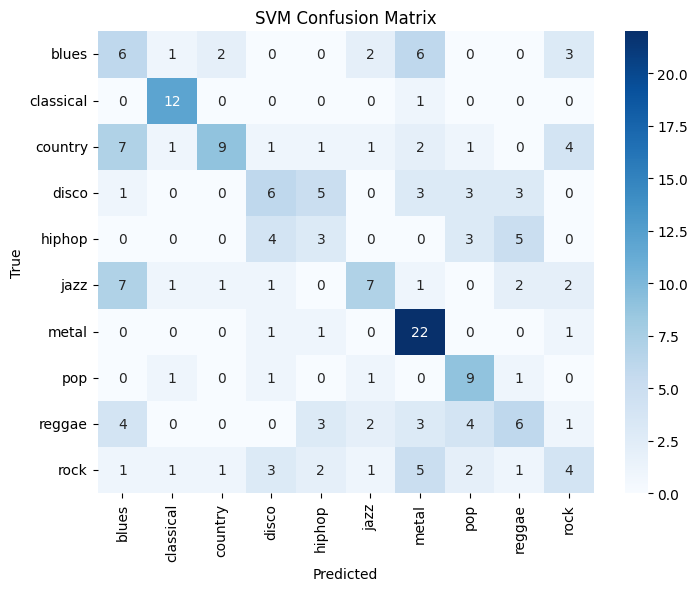

In [16]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

y_test_labels = np.argmax(y_test, axis=1)

svm_preds = svm_model.predict(x_test_flattened)
svm_cm = confusion_matrix(y_test_labels, svm_preds)


# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

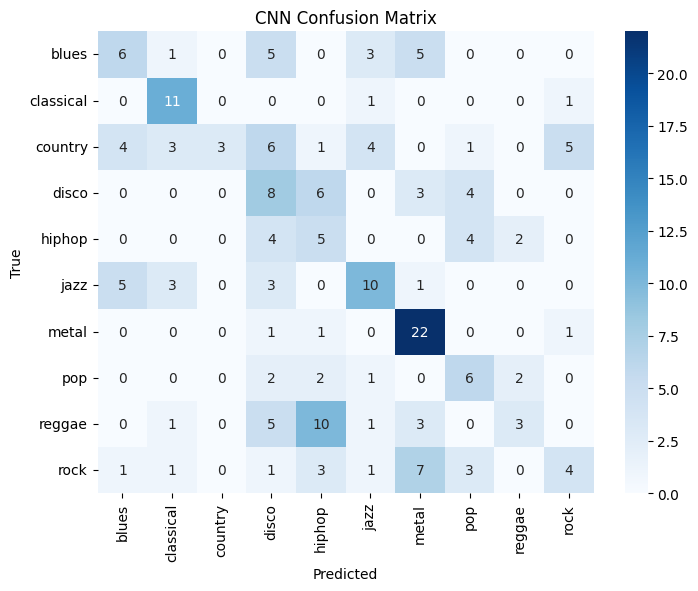

In [19]:
cnn_cm = confusion_matrix(y_test_labels, y_pred_cnn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


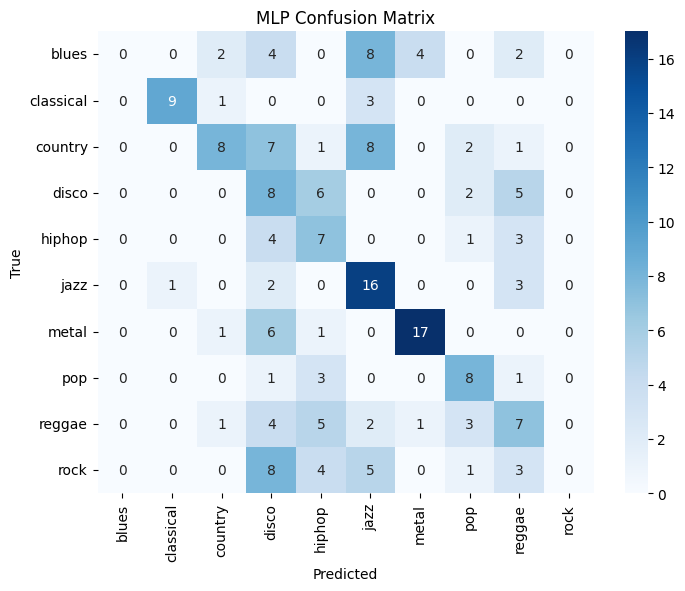

In [21]:
mlp_cm = confusion_matrix(y_test_labels, y_pred_mlp)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
